<a href="https://colab.research.google.com/github/Jayanavya/Kaggle_Assignment_Group_2/blob/main/Kaggle_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Spaceship Kaggle code

## Install & Import Libraries


In [ ]:
# Install additional libraries
!pip install lightgbm xgboost shap

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb


## Load Data

In [ ]:
# Load Kaggle Spaceship Titanic dataset
trainDF = pd.read_csv('https://raw.githubusercontent.com/Kaggle-project-group2/Kaggle_Assignment_Group_2/refs/heads/main/train.csv')
testDF = pd.read_csv('https://raw.githubusercontent.com/Kaggle-project-group2/Kaggle_Assignment_Group_2/refs/heads/main/test.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/Kaggle-project-group2/Kaggle_Assignment_Group_2/refs/heads/main/sample_submission.csv')

print("Train Shape:", trainDF.shape)
print("Test Shape:", testDF.shape)


Train Shape: (8693, 14)
Test Shape: (4277, 13)


In [ ]:
trainDF.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
testDF.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## Pre-Processing Function

In [ ]:
def preprocess(df):
    # Split Cabin into Deck, Num, Side
    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    # Convert Cabin_num to numeric
    df['Cabin_num'] = pd.to_numeric(df['Cabin_num'], errors='coerce')

    # Handle missing categorical values (fill with mode)
    cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Handle missing numeric values (fill with median)
    num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    # Drop Name and Cabin
    df = df.drop(['Name', 'Cabin'], axis=1)

    return df

# Apply preprocessing
trainDF = preprocess(trainDF)
testDF = preprocess(testDF)


/tmp/ipython-input-6-4174805726.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/tmp/ipython-input-6-4174805726.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [ ]:
# Check missing values
print("Missing values after preprocessing:")
print(trainDF.isnull().sum())


Missing values after preprocessing:
PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Cabin_num       0
Side            0
dtype: int64


## EDA

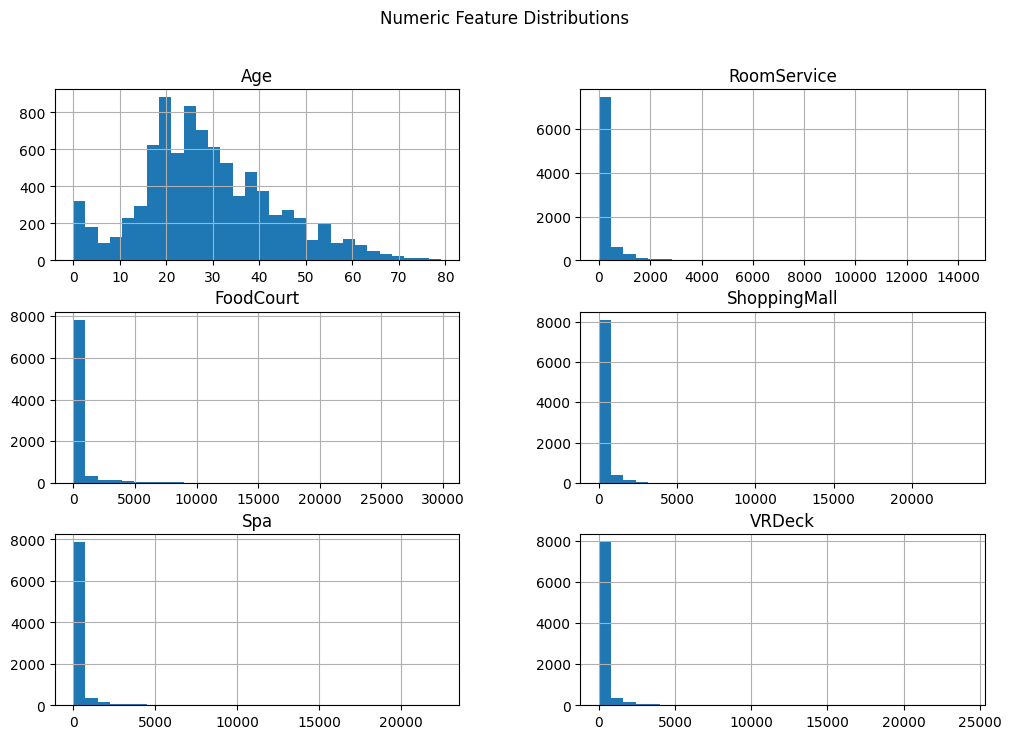

In [ ]:
#  Distribution of numeric features
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
trainDF[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

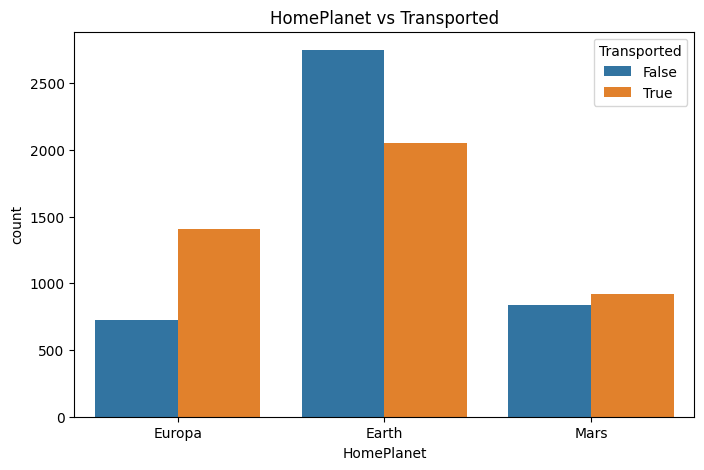

In [ ]:
#  Bar chart for categorical variable vs Transported
plt.figure(figsize=(8,5))
sns.countplot(data=trainDF, x='HomePlanet', hue='Transported')
plt.title("HomePlanet vs Transported")
plt.show()

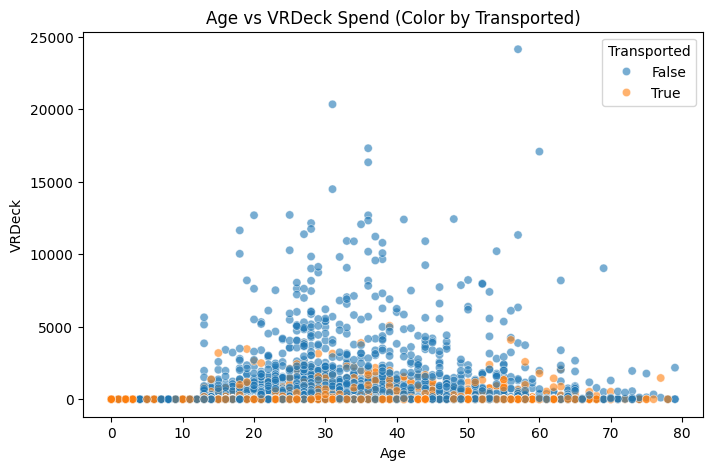

In [ ]:
#  Scatter plot for numeric relationship
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='VRDeck', hue='Transported', data=trainDF, alpha=0.6)
plt.title("Age vs VRDeck Spend (Color by Transported)")
plt.show()

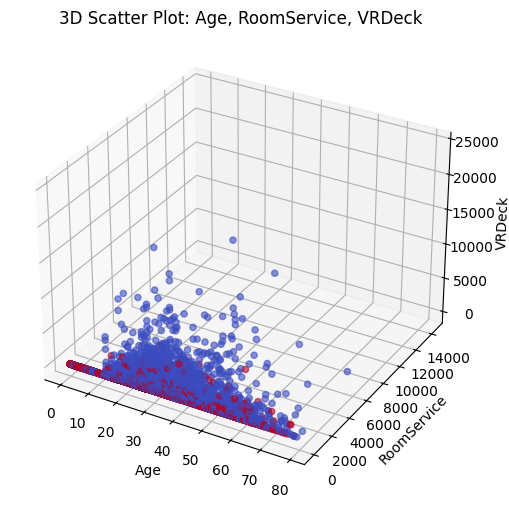

In [ ]:
#  3D Scatter (Age, RoomService, VRDeck)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainDF['Age'], trainDF['RoomService'], trainDF['VRDeck'],
           c=trainDF['Transported'], cmap='coolwarm', alpha=0.6)
ax.set_xlabel('Age'); ax.set_ylabel('RoomService'); ax.set_zlabel('VRDeck')
plt.title("3D Scatter Plot: Age, RoomService, VRDeck")
plt.show()

## Encode Categorical Variables




This cell applies label encoding to categorical features shared by training and test datasets. It concatenates both datasets' feature columns to ensure consistent encoding, fits a `LabelEncoder` on the combined data, and then transforms each dataset separately. This prevents mismatched label mappings between train and test sets, which is crucial for maintaining model integrity during training and inference.


In [ ]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
for col in cat_features:
    le = LabelEncoder()
    combined = pd.concat([trainDF[col], testDF[col]], axis=0)
    le.fit(combined)
    trainDF[col] = le.transform(trainDF[col])
    testDF[col] = le.transform(testDF[col])



This cell prepares categorical data for machine learning by applying one-hot encoding to selected features, ensuring consistent feature spaces between training and test sets. It aligns encoded columns by adding missing features with zero values, preserving the dimensional integrity required for model compatibility across datasets. This step is essential to avoid mismatched input shapes during prediction or evaluation phases.












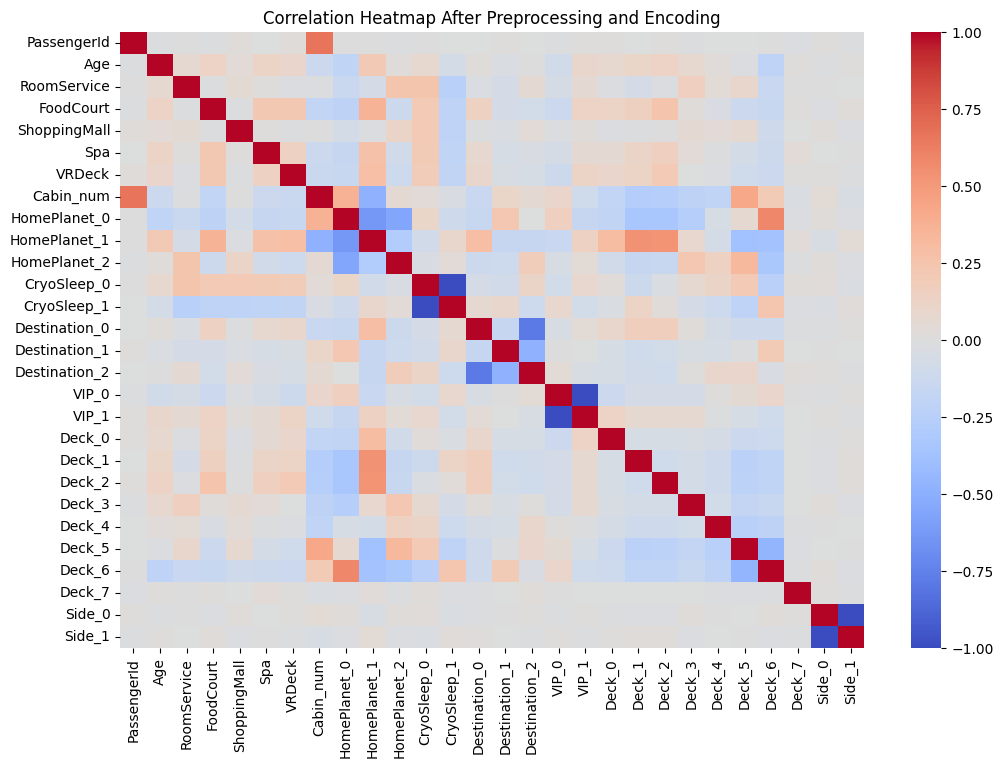

In [ ]:
# Define categorical columns again
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

# Define features and target
X = trainDF.drop('Transported', axis=1)
y = trainDF['Transported']
X_test = testDF.copy()


# Encode categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# Align columns after one-hot encoding - crucial for consistent feature sets
train_cols = list(X.columns)
test_cols = list(X_test.columns)

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X[c] = 0

X_test = X_test[train_cols] # Ensure the order of columns is the same

# Now calculate and display the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap After Preprocessing and Encoding")
plt.show()

### Network analysis

In [ ]:
# --- Correlation Network Focused on 'Transported' ---
import networkx as nx
import matplotlib.pyplot as plt

# Ensure 'Transported' is numeric (0/1)
if 'Transported' in trainDF.columns:
    trainDF['Transported'] = trainDF['Transported'].astype(int)

# Compute correlation matrix including target
target_corr = trainDF.corr()['Transported'].drop('Transported')

# Sort by correlation strength
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("\n--- Correlation of Features with 'Transported' ---")
print(target_corr_sorted)



--- Correlation of Features with 'Transported' ---
CryoSleep       0.460132
RoomService     0.241124
Spa             0.218545
VRDeck          0.204874
HomePlanet      0.115461
Deck            0.114941
Destination     0.108152
Side            0.101397
Age             0.074233
FoodCourt       0.045583
Cabin_num       0.044502
VIP             0.037261
PassengerId     0.021491
ShoppingMall    0.009391
Name: Transported, dtype: float64


In [ ]:
# Set threshold for significant correlation with target
threshold = 0.05  # Lower threshold since correlations may be small

## Define Features and Target

This cell prepares data for supervised machine learning. It extracts the target variable y by converting the Transported column to integers, and defines X by removing Transported and PassengerId from trainDF. For the test set, it isolates PassengerId as test_ids and defines X_test by excluding it, ensuring consistency in features for model prediction.












In [ ]:
y = trainDF['Transported'].astype(int)
X = trainDF.drop(['Transported', 'PassengerId'], axis=1)
test_ids = testDF['PassengerId']
X_test = testDF.drop(['PassengerId'], axis=1)

## Train-Test Split & Scaling

This cell splits the dataset into training and validation sets, then standardizes selected numerical features using z-score normalization via StandardScaler. Scaling is fit on the training set to avoid data leakage and applied consistently to validation and test sets. This preprocessing ensures features are on comparable scales, which is critical for gradient-based models like Logistic Regression.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric columns for LR
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

## Models

This function uses SHAP (SHapley Additive exPlanations) to interpret tree-based model predictions. It generates a summary plot to visualize feature importance across the dataset and a dependence plot to examine how the feature "Age" influences the output. The SHAP TreeExplainer computes the contribution of each feature to the prediction, supporting model transparency and interpretability in complex machine learning systems.


In [ ]:
def explain_with_shap(model, X_val, model_name="Model"):
    """Explain tree-based model predictions using SHAP."""
    print(f"\nGenerating SHAP plots for {model_name}...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)

    # Summary Plot
    shap.summary_plot(shap_values, X_val, show=False)
    plt.title(f"{model_name} - SHAP Summary")
    plt.show()

    # Dependence Plot (example for Age)
    shap.dependence_plot('Age', shap_values, X_val, show=False)
    plt.title(f"{model_name} - SHAP Dependence for Age")
    plt.show()


This function generates a Kaggle submission file by predicting outcomes on the test set using a trained model. If scaling is required (e.g., for linear models), it applies a `StandardScaler` to specified numeric features before prediction. Otherwise, it directly uses the model. This modular design supports both scaled and unscaled workflows, ensuring compatibility with different model requirements during deployment.


In [ ]:
def create_submission(model, X_test, sample_submission, filename, is_scaled=False, scaler=None):
    """Generate Kaggle submission file."""
    if is_scaled and scaler is not None:
        # Apply scaling for Logistic Regression
        num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        X_test_scaled = X_test.copy()
        X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
        preds = model.predict(X_test_scaled)
    else:
        preds = model.predict(X_test)

    # Convert to bool as required by Kaggle
    sample_submission['Transported'] = preds.astype(bool)
    sample_submission.to_csv(filename, index=False)
    print(f"Submission file saved as: {filename}")


### Logistic Regression

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
print("Logistic Regression Accuracy:", accuracy_score(y_val, lr.predict(X_val_scaled)))

Logistic Regression Accuracy: 0.7705577918343876


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'solver': ['liblinear', 'saga'],  # solvers that support both l1 and l2
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization strength (lower = more regularization)
}

# Initialize logistic regression (max_iter high enough to ensure convergence)
lr = LogisticRegression(max_iter=500)

# Set up GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on validation set
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val_scaled)
print("Validation Accuracy with Tuned Model:", accuracy_score(y_val, val_preds))


Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.7899061282965002
Validation Accuracy with Tuned Model: 0.772857964347326


In [ ]:
create_submission(best_model, X_test_scaled, sample_submission.copy(), 'submission_lr.csv', is_scaled=True, scaler=scaler)

Submission file saved as: submission_lr.csv


### XGBoost

In [ ]:
# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_model.predict(X_val)))

XGBoost Accuracy: 0.7998849913743531



Generating SHAP plots for XGBoost...


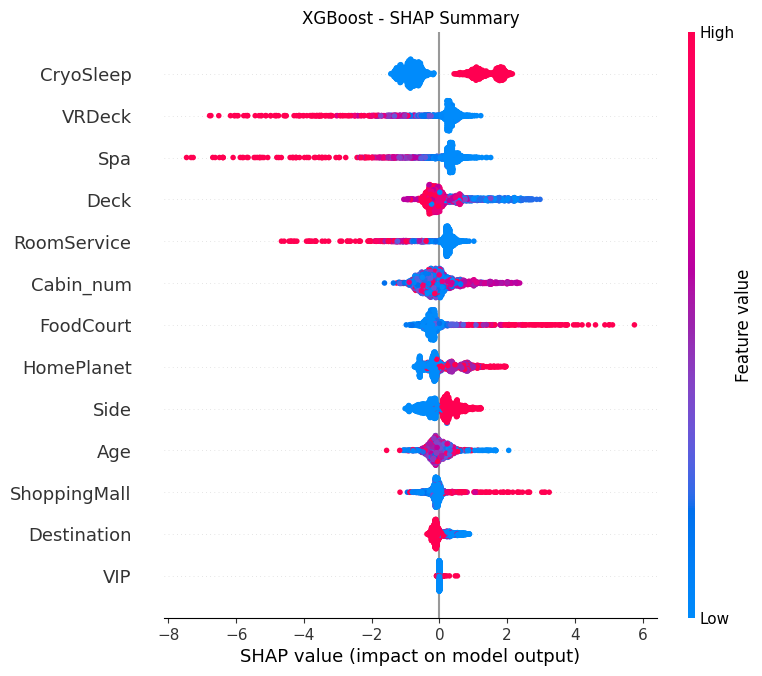

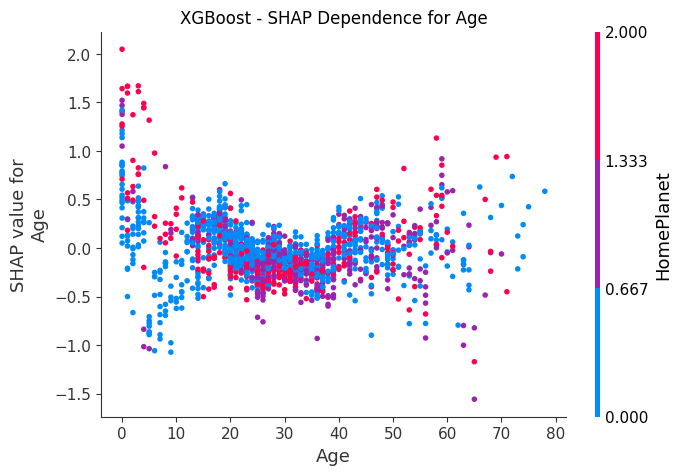

Submission file saved as: submission_xgb.csv


In [ ]:
# For XGBoost
explain_with_shap(xgb_model, X_val, model_name="XGBoost")
create_submission(xgb_model, X_test, sample_submission.copy(), 'submission_xgb.csv')


### LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
print("LightGBM Accuracy:", accuracy_score(y_val, lgb_model.predict(X_val)))

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
LightGBM Accuracy: 0.8039102932719954



Generating SHAP plots for LightGBM...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


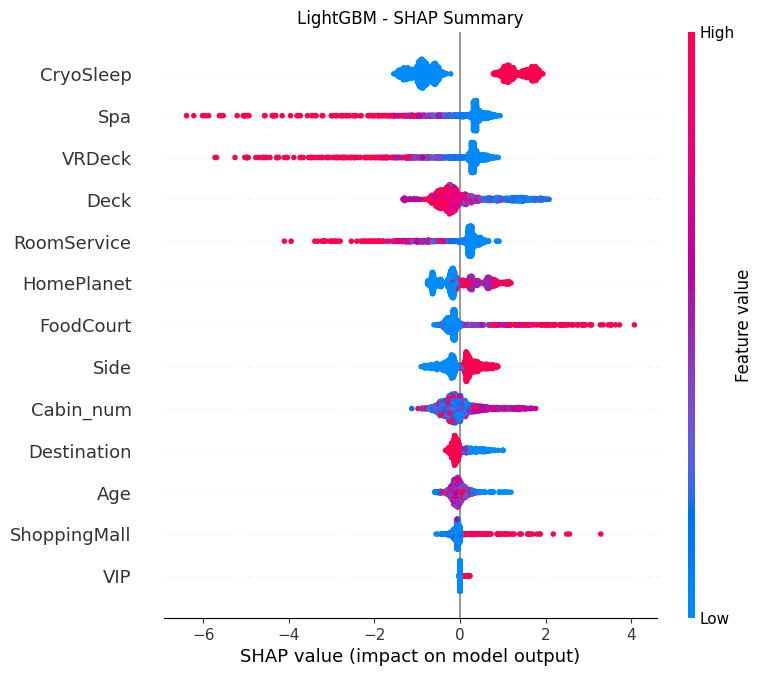

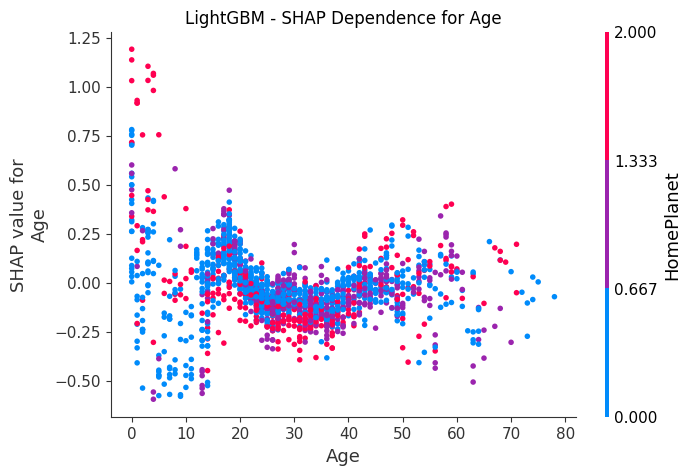

In [ ]:
explain_with_shap(lgb_model, X_val, model_name="LightGBM")


In [ ]:
create_submission(lgb_model, X_test, sample_submission.copy(), 'submission_lgb.csv')

Submission file saved as: submission_lgb.csv


## Network analysis

In [ ]:
# Build graph
G = nx.Graph()

# Add Transported as main node
G.add_node('Transported')

# Add nodes for features and edges if correlation >= threshold
for feature, corr_val in target_corr.items():
    if abs(corr_val) >= threshold:
        G.add_node(feature)
        G.add_edge('Transported', feature, weight=abs(corr_val))


Features connected to 'Transported' (|corr| >= 0.05): ['Transported', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService', 'Spa', 'VRDeck', 'Deck', 'Side']


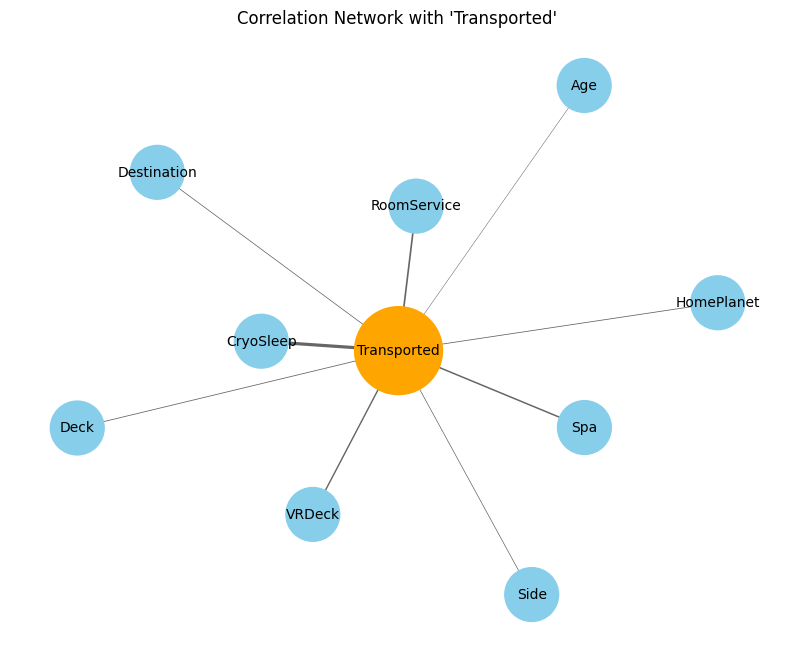

In [ ]:
# Print key info
print(f"\nFeatures connected to 'Transported' (|corr| >= {threshold}): {list(G.nodes)}")

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Node size and color
node_sizes = [4000 if node == 'Transported' else 1500 for node in G.nodes()]
node_colors = ['orange' if node == 'Transported' else 'skyblue' for node in G.nodes()]

# Edge width by correlation strength
edge_widths = [5 * G[u][v]['weight'] for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Correlation Network with 'Transported'")
plt.axis('off')
plt.show()

In [ ]:
# Print top 5 features most correlated with Transported
print("\nTop 5 Features most correlated with 'Transported':")
print(target_corr_sorted.head(5))


Top 5 Features most correlated with 'Transported':
CryoSleep      0.460132
RoomService    0.241124
Spa            0.218545
VRDeck         0.204874
HomePlanet     0.115461
Name: Transported, dtype: float64


In [ ]:

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_val, preds))
    print(classification_report(y_val, preds))

In [ ]:
!pip install xgboost --upgrade -q

In [ ]:
# Step 2: Imports
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Step 3: Parameter grid
params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

In [ ]:
# Step 4: Model setup
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    random_state=42
)

In [ ]:
# Step 5: Grid Search setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='accuracy',
    cv=2,
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Step 5: Grid Search setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='accuracy',
    cv=2,
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Step 7: Results
print("Best Accuracy Score from GridSearchCV:", grid_search.best_score_)
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

In [ ]:
# Step 7: Results
print("Best Accuracy Score from GridSearchCV:", grid_search.best_score_)
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

In [ ]:
# Ensure your test data has same features as training data
X_test_final = pd.get_dummies(df_test, drop_first=True)
X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=0)

# Predict using best model
predictions = best_model.predict(X_test_final)

# Save submission
sample_submission['Transported'] = predictions.astype(bool)
sample_submission.to_csv('submission.csv', index=False)

# Preview
sample_submission.head()

In [ ]:
predictions = best_model.predict(X_test_final)
sample_submission['Transported'] = predictions.astype(bool)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()